In [1]:
# import packages that we need use
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.model_selection import cross_val_score
from copy import deepcopy
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
# import original data
raw_data = pd.read_csv("2020_Competition_Training.csv")
raw_data.head(20)
raw_data.shape

/Users/kiki/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (80) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


(69572, 826)

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69572 entries, 0 to 69571
Columns: 826 entries, person_id_syn to submcc_rsk_chol_ind
dtypes: float64(392), int64(412), object(22)
memory usage: 438.4+ MB


In [4]:
# Trans persion ID to the Index
data_train = raw_data.drop(columns='person_id_syn')
data_train.head()

,transportation_issues,src_platform_cd,sex_cd,est_age,smoker_current_ind,smoker_former_ind,lang_spoken_cd,mabh_seg,cci_score,dcsi_score,...,submcc_rar_scl_ind,rx_gpi2_74_ind,rx_gpi2_89_ind,rx_gpi2_96_ind,submcc_rsk_obe_ind,rx_gpi2_22_ind,submcc_rsk_synx_ind,submcc_rsk_coag_ind,submcc_rsk_othr_ind,submcc_rsk_chol_ind
0,0,EM,F,62,1,0,ENG,UNK,3,1,...,0,0,0,0,0,0,0,0,0,0
1,0,EM,F,59,1,0,ENG,C2,1,2,...,0,0,0,0,1,0,0,0,0,1
2,1,EM,F,63,0,0,ENG,UNK,3,0,...,0,0,0,0,0,0,0,0,0,1
3,0,EM,M,75,0,0,ENG,H6,3,0,...,0,0,0,0,1,0,0,0,0,1
4,0,EM,M,51,1,0,ENG,UNK,3,1,...,0,0,0,0,0,0,0,0,0,1


In [5]:
#### missing value condition

def missing_value_table(df):
    mis_val = df.isnull().sum()
    # %
    mis_val_percent = 100*df.isnull().sum()/len(df)
    # merge
    mis_val_table = pd.concat([mis_val, mis_val_percent],axis = 1)
    mis_val_rename = mis_val_table.rename(columns = {0:'Missing Value', 1:'% of total values'})
    # filter no missing and sort
    mis_val_rename = mis_val_rename[mis_val_rename.iloc[:,1]!=0].sort_values('% of total values', ascending=False)
    return mis_val_rename
missing_value_table(data_train)[:10]

,Missing Value,% of total values
cons_homstat,19280,27.712298
cons_retail_buyer,19279,27.710861
cons_ret_y,19279,27.710861
cons_n2029_y,19279,27.710861
cons_n65p_y,19278,27.709423
cons_n2pbl,19278,27.709423
cons_veteran_y,19278,27.709423
cons_n2pmv,19278,27.709423
cons_hcaccprf_h,19278,27.709423
cons_hcaccprf_p,19278,27.709423


In [6]:
data_train.dtypes.value_counts()

int64      412
float64    392
object      21
dtype: int64

In [7]:
# drop features which have high correlation with others

data_train = data_train.drop(columns = [
    'state_cd','credit_prcnt_agencyfirstmtg','credit_num_studentloan','credit_num_mtgcredit_new','credit_num_nonagn1stmorg_30to59dpd',
    'credit_num_nonagn1stmorg_60to89dpd','credit_num_nonagn1stmorg_90to119dp','credit_num_nonagn1stmorg_bankruptc',
    'credit_num_nonagn1stmorg_collectio','credit_minmob_1stmtgcredit','credit_minmob_agencyfirstmtg',
    'credit_num_1stmtg_30to59dpd','credit_num_1stmtg_60to89dpd','credit_num_1stmtg_bankruptcy','credit_num_1stmtg_collections',
    'credit_num_1stmtg_severederog','credit_num_1stmtgcredit_new','credit_num_agencyfirstmtg_60dpd',
    'credit_num_autobank_new','credit_num_autofinance_new','credit_num_consumerfinance_new','credit_num_heloc_severederog',
    'credit_bal_nonagn1stmorg_collectio','credit_bal_nonagnfirstmtg_60dpd','credit_bal_agency1stmorg_collectio',
    'credit_bal_1stmtg_30to59dpd','credit_bal_1stmtg_60to89dpd','credit_bal_1stmtg_collections','credit_bal_1stmtg_severederog',
    'credit_bal_agencyfirstmtg_new','credit_bal_mtgcredit_new','src_platform_cd','zip_cd','med_ambulance_visit_ct_pmpm',
    'med_er_visit_ct_pmpm','med_ip_acute_admit_ct_pmpm','med_ip_acute_admit_days_pmpm','med_ip_ltach_admit_ct_pmpm',
    'med_ip_ltach_admit_days_pmpm','med_ip_maternity_admit_ct_pmpm','med_ip_maternity_admit_days_pmpm','med_ip_mhsa_admit_ct_pmpm',
    'med_ip_mhsa_admit_days_pmpm','med_ip_rehab_admit_ct_pmpm','med_ip_rehab_admit_days_pmpm','med_ip_snf_admit_ct_pmpm',
    'med_ip_snf_admit_days_pmpm','med_outpatient_visit_ct_pmpm','med_physician_office_visit_ct_pmpm',
    'med_urgent_care_visit_ct_pmpm','bh_aoth_ind',
    'bh_cdto_ind','hlth_pgm_slvrsnkr_refer_status'
])
data_train.dtypes.value_counts()

int64      403
float64    351
object      18
dtype: int64

In [8]:
# object type preprocessing
data_train.select_dtypes('object').apply(pd.Series.nunique,axis=0)

sex_cd                       2
lang_spoken_cd               3
mabh_seg                    16
cms_ra_factor_type_cd        9
cons_cmys                   13
cons_hhcomp                 13
cons_homstat                 5
hedis_ami                    2
hedis_cmc_ldc_c_control      2
hedis_cmc_ldc_c_screen       2
hedis_dia_eye                2
hedis_dia_hba1c_ge9          2
hedis_dia_hba1c_test         2
hedis_dia_ldc_c_control      2
hedis_dia_ldc_c_screen       2
hedis_dia_ma_nephr           2
rucc_category                9
cnty_cd                    109
dtype: int64

In [9]:
# make the "object" feature into one-hot value

le = LabelEncoder()
for col in data_train:
    if data_train[col].dtype == 'object':
        if len(list(data_train[col].unique()))<=2:
            le.fit(data_train[col])
            data_train[col]=le.transform(data_train[col])
data_train = pd.get_dummies(data_train)
data_train.head(10)

,transportation_issues,sex_cd,est_age,smoker_current_ind,smoker_former_ind,cci_score,dcsi_score,fci_score,hcc_weighted_sum,betos_d1c_pmpm_ct,...,cnty_cd_86,cnty_cd_87,cnty_cd_89,cnty_cd_9,cnty_cd_91,cnty_cd_93,cnty_cd_95,cnty_cd_97,cnty_cd_99,cnty_cd_other
0,0,0,62,1,0,3,1,2,0,0.0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,59,1,0,1,2,5,3,0.0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,63,0,0,3,0,6,0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,75,0,0,3,0,2,0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,51,1,0,3,1,4,0,0.0,...,0,0,0,0,0,0,0,0,0,1
5,0,0,73,0,0,4,1,1,2,0.0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,57,0,0,1,0,2,2,0.0,...,0,0,0,0,0,0,0,0,0,1
7,0,0,83,0,0,4,0,4,0,0.0,...,0,0,0,0,0,0,0,0,0,1
8,1,0,56,0,0,6,3,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
9,0,1,69,0,0,2,0,2,0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [10]:
print(data_train.shape)
data_train.keys()

(69572, 941)


Index(['transportation_issues', 'sex_cd', 'est_age', 'smoker_current_ind',
       'smoker_former_ind', 'cci_score', 'dcsi_score', 'fci_score',
       'hcc_weighted_sum', 'betos_d1c_pmpm_ct',
       ...
       'cnty_cd_86', 'cnty_cd_87', 'cnty_cd_89', 'cnty_cd_9', 'cnty_cd_91',
       'cnty_cd_93', 'cnty_cd_95', 'cnty_cd_97', 'cnty_cd_99',
       'cnty_cd_other'],
      dtype='object', length=941)

In [11]:
#EDA Analysis

train_labels = data_train['transportation_issues']
train_labels

0        0
1        0
2        1
3        0
4        0
        ..
69567    0
69568    0
69569    0
69570    0
69571    1
Name: transportation_issues, Length: 69572, dtype: int64

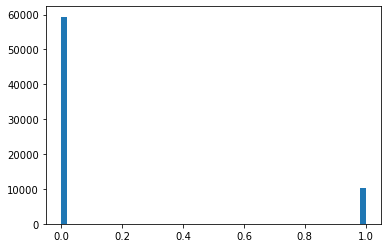

array(1.99863202)

In [12]:
# Sample skewness observation
fig = plt.subplots()
plt.hist(data_train['transportation_issues'], bins=50)
plt.show()
stats.mstats.skew(data_train['transportation_issues']).data

In [13]:
correlations = data_train.corr()['transportation_issues'].sort_values() 
correlations.head(10)

cms_ra_factor_type_cd_CN   -0.184651
est_age                    -0.182090
cons_n65p_y                -0.159021
cons_homstat_Y             -0.122866
cons_hhcomp_B              -0.088952
mabh_seg_H2                -0.084452
cons_n2pmv                 -0.079036
credit_hh_mtgcredit_new    -0.074500
pdc_dep                    -0.072481
cmsd2_skn_radiation_ind    -0.067798
Name: transportation_issues, dtype: float64

In [14]:
correlations.tail(10)

rx_gpi2_80_ind        NaN
submcc_pre_mul_ind    NaN
rx_gpi2_98_ind        NaN
rx_gpi2_20_ind        NaN
submcc_brn_acc_ind    NaN
submcc_rsk_an_ind     NaN
submcc_hiv_kapo_ind   NaN
rx_gpi2_70_ind        NaN
rx_gpi2_96_ind        NaN
submcc_rsk_othr_ind   NaN
Name: transportation_issues, dtype: float64

In [15]:
correlations.keys()

Index(['cms_ra_factor_type_cd_CN', 'est_age', 'cons_n65p_y', 'cons_homstat_Y',
       'cons_hhcomp_B', 'mabh_seg_H2', 'cons_n2pmv', 'credit_hh_mtgcredit_new',
       'pdc_dep', 'cmsd2_skn_radiation_ind',
       ...
       'rx_gpi2_80_ind', 'submcc_pre_mul_ind', 'rx_gpi2_98_ind',
       'rx_gpi2_20_ind', 'submcc_brn_acc_ind', 'submcc_rsk_an_ind',
       'submcc_hiv_kapo_ind', 'rx_gpi2_70_ind', 'rx_gpi2_96_ind',
       'submcc_rsk_othr_ind'],
      dtype='object', length=941)

<function matplotlib.pyplot.show(*args, **kw)>

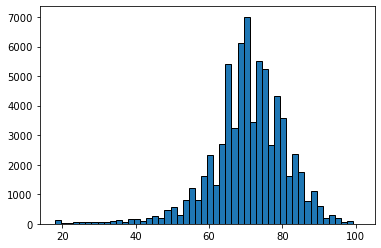

In [16]:
plt.hist(data_train['est_age'], edgecolor='k', bins=50)
plt.show

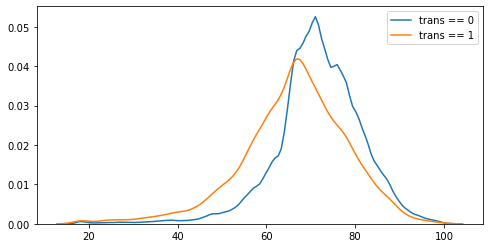

In [17]:
plt.figure(figsize=(8, 4))
sns.kdeplot(data_train.loc[data_train['transportation_issues']==0, 'est_age'], label = 'trans == 0')
sns.kdeplot(data_train.loc[data_train['transportation_issues']==1, 'est_age'], label = 'trans == 1')
plt.show()

In [18]:
extra_data = data_train[['transportation_issues','cms_ra_factor_type_cd_CN','est_age','cons_n65p_y','cons_homstat_Y','cons_hhcomp_B']]
extra_data_corrs = extra_data.corr()
extra_data_corrs

,transportation_issues,cms_ra_factor_type_cd_CN,est_age,cons_n65p_y,cons_homstat_Y,cons_hhcomp_B
transportation_issues,1.000000,-0.184651,-0.182090,-0.159021,-0.122866,-0.088952
cms_ra_factor_type_cd_CN,-0.184651,1.000000,0.338176,0.237811,0.234586,0.163908
est_age,-0.182090,0.338176,1.000000,0.488588,0.164561,0.120942
cons_n65p_y,-0.159021,0.237811,0.488588,1.000000,0.225382,0.181584
cons_homstat_Y,-0.122866,0.234586,0.164561,0.225382,1.000000,0.318877
cons_hhcomp_B,-0.088952,0.163908,0.120942,0.181584,0.318877,1.000000


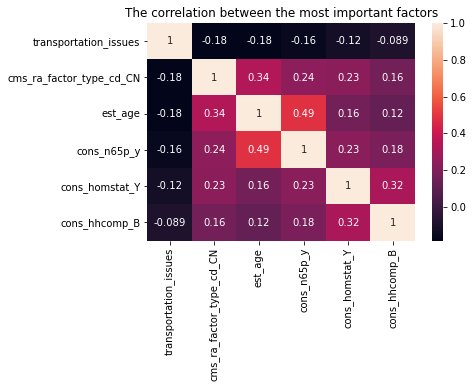

In [19]:
sns.heatmap(extra_data_corrs, annot=True)
plt.title('The correlation between the most important factors')
plt.show()

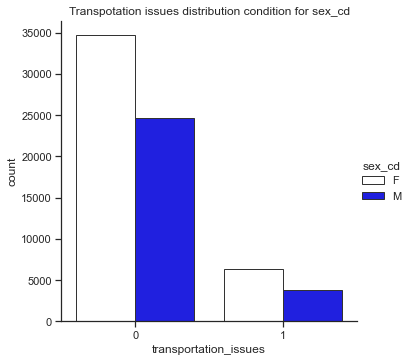

<Figure size 864x576 with 0 Axes>

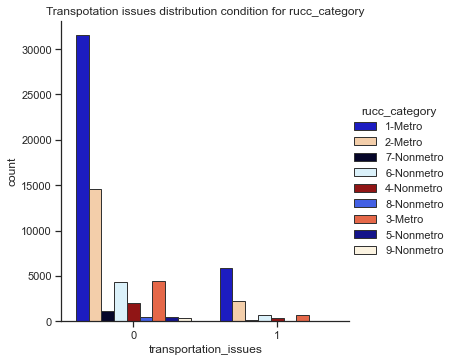

<Figure size 864x576 with 0 Axes>

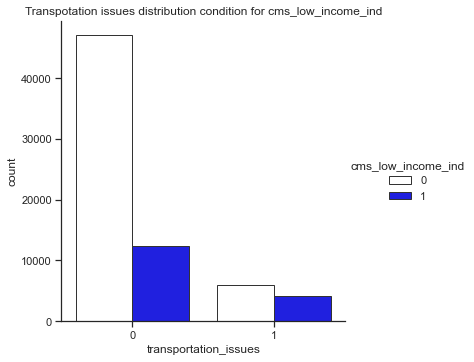

<Figure size 864x576 with 0 Axes>

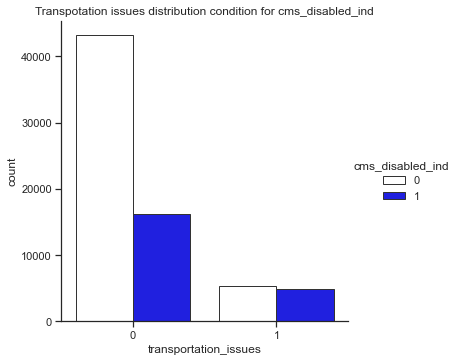

<Figure size 864x576 with 0 Axes>

In [20]:
sns.set(style="ticks", color_codes=True)
for i, source in enumerate(["sex_cd","rucc_category","cms_low_income_ind","cms_disabled_ind"]):
    sns.catplot(x="transportation_issues", hue=source,kind="count",edgecolor=".20",
            palette="flag",data=raw_data)
    plt.title('Transpotation issues distribution condition for %s' % source)
    plt.figure(figsize=(12, 8))

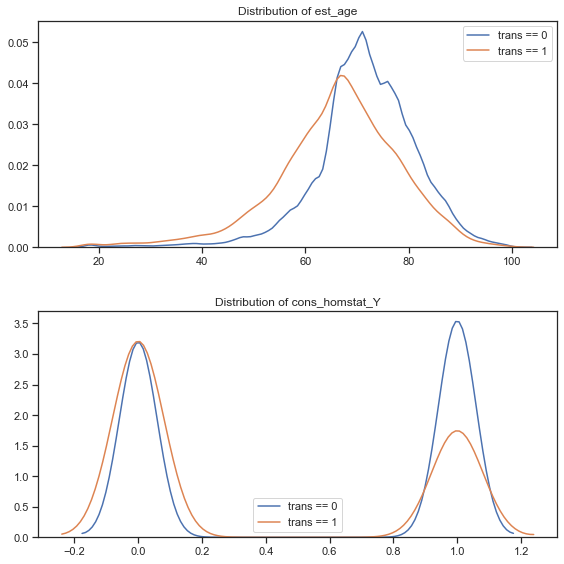

In [21]:
plt.figure(figsize=(8, 8)) 
for i, source in enumerate(['est_age','cons_homstat_Y']):
    plt.subplot(2, 1, i+1)
    sns.kdeplot(data_train.loc[data_train['transportation_issues']==0, source], label = 'trans == 0')
    sns.kdeplot(data_train.loc[data_train['transportation_issues']==1, source], label = 'trans == 1')
    plt.title('Distribution of %s' % source)
plt.tight_layout(h_pad=2.5)
plt.show()

In [22]:
# import package about feature processing

from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
import tempfile

import matplotlib as mpl
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import roc_auc_score,accuracy_score,precision_score,recall_score,f1_score,roc_curve
from collections import Counter

In [23]:
# Deal with missing value, training set sampling and data standardization

label = data_train['transportation_issues']
train = data_train.drop(columns = ['transportation_issues'])

x_train, x_test, y_train, y_test = train_test_split(train, label, test_size = 0.2, random_state = 0)
features = list(x_train.columns)

imp = SimpleImputer(missing_values=np.nan, strategy='median') 
std = StandardScaler()
imp.fit(x_train)
x_train = imp.transform(x_train)
x_test = imp.transform(x_test)

std.fit(x_train)
x_train = std.transform(x_train)
x_test = std.transform(x_test)

In [24]:
# Target Samples' balance condition 
eps = 0.001 # 0 => 0.1￠
(neg, pos), total = np.bincount(data_train['transportation_issues']), data_train.shape[0]
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
    Total: 69572
    Positive: 10197 (14.66% of total)



In [25]:
# Because this is an extremely unbalanced sample，so we need to use Confusion Matrix
# There are four probabilitis: True Positive, False Positive, False Negative, True Negative
# Precision: TP/(TP+FP); Recall: FN(FN+TN); F1-score: F=2PR/(P+R); ROC(TPR,FPR); 

### Sample equalization processing

In [26]:
metrics = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc')
]

BATCH_SIZE = 2048
BUFFER_SIZE = 100000
EPOCHS = 30

model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(x_train.shape[-1], )),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

In [27]:
# max mode: monitor has stopped increasing
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20,
    mode='max',
    restore_best_weights=True
)

In [28]:
model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-3),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=metrics
)
# checkpoint the initial weights
initial_weights = model.get_weights()

In [29]:
print('Training Zero Bias Model')
model.set_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(x_test, y_test), 
    verbose=0,
    callbacks=[early_stopping],
)
zero_preditions = model.predict(x_test, batch_size=BATCH_SIZE)

Training Zero Bias Model


In [30]:
print('Training Care Bias Model')
model.set_weights(initial_weights)
model.layers[-1].bias.assign([np.log(pos/neg, dtype=np.float32)])
care_bias_history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(x_test, y_test), 
    verbose=0,
    callbacks=[early_stopping])
care_preditions = model.predict(x_test, batch_size=BATCH_SIZE)

Training Care Bias Model


In [31]:
print('Training Weighted Model')
weight_for_0 = total / neg / 2.0
weight_for_1 = total / pos / 2.0
class_weight = {0: weight_for_0, 1: weight_for_1}

model.set_weights(initial_weights)
weighted_history = model.fit(
    x_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=EPOCHS, 
    validation_data=(x_test, y_test), 
    verbose=0,
    callbacks=[early_stopping],
    class_weight=class_weight,
)
weighted_preditions = model.predict(x_test, batch_size=BATCH_SIZE)

Training Weighted Model
Restoring model weights from the end of the best epoch.
Epoch 00026: early stopping


In [32]:
print('Training Oversampling Model')
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# filter is so slowly
# pos_ds = train_ds.filter(lambda x,y: y == 1).shuffle(100000).repeat()
# neg_ds = train_ds.filter(lambda x,y: y == 0).shuffle(100000).repeat()

pos_indices = y_train == 1
x_pos, x_neg = x_train[pos_indices], x_train[~pos_indices]
y_pos, y_neg = y_train[pos_indices], y_train[~pos_indices]
ds_pos = tf.data.Dataset.from_tensor_slices((x_pos, y_pos)).shuffle(BUFFER_SIZE).repeat()
ds_neg = tf.data.Dataset.from_tensor_slices((x_neg, y_neg)).shuffle(BUFFER_SIZE).repeat()
ds_resampled = tf.data.experimental.sample_from_datasets([ds_pos, ds_neg], weights=[0.5, 0.5])
ds_resampled = ds_resampled.batch(BATCH_SIZE).prefetch(2)
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)

ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test)).cache()
ds_test = ds_test.batch(BATCH_SIZE).prefetch(2) 

model.set_weights(initial_weights)
oversampling_history = model.fit(
    ds_resampled,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    validation_data=ds_test,
    verbose=0,
    callbacks=[early_stopping]
)
oversampling_preditions = model.predict(x_test, batch_size=BATCH_SIZE)

Training Oversampling Model
Restoring model weights from the end of the best epoch.
Epoch 00023: early stopping


In [33]:
from sklearn.metrics import roc_curve,auc

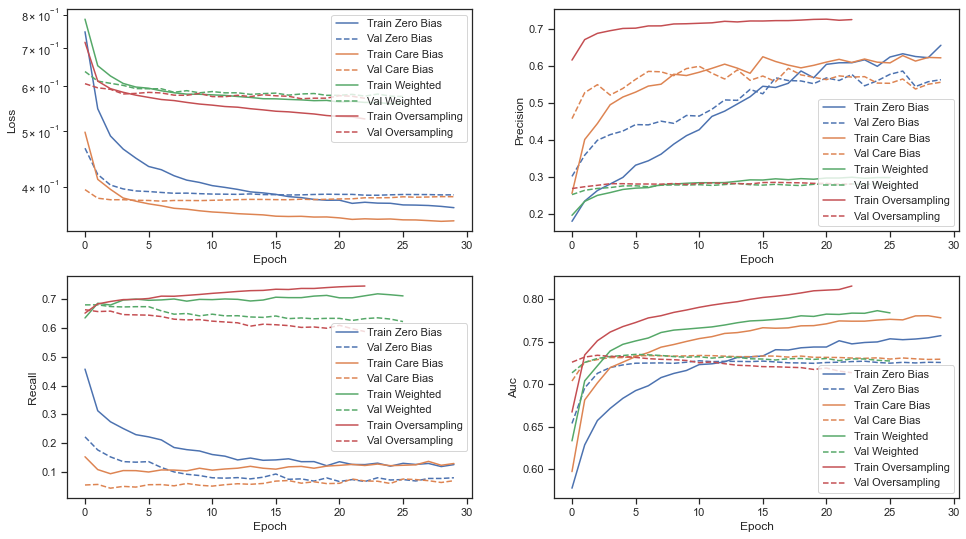

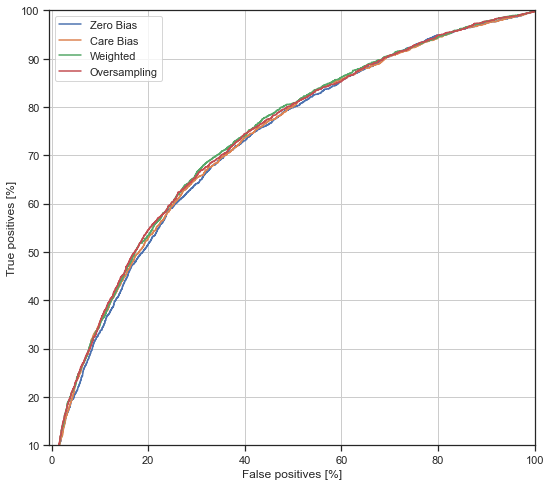

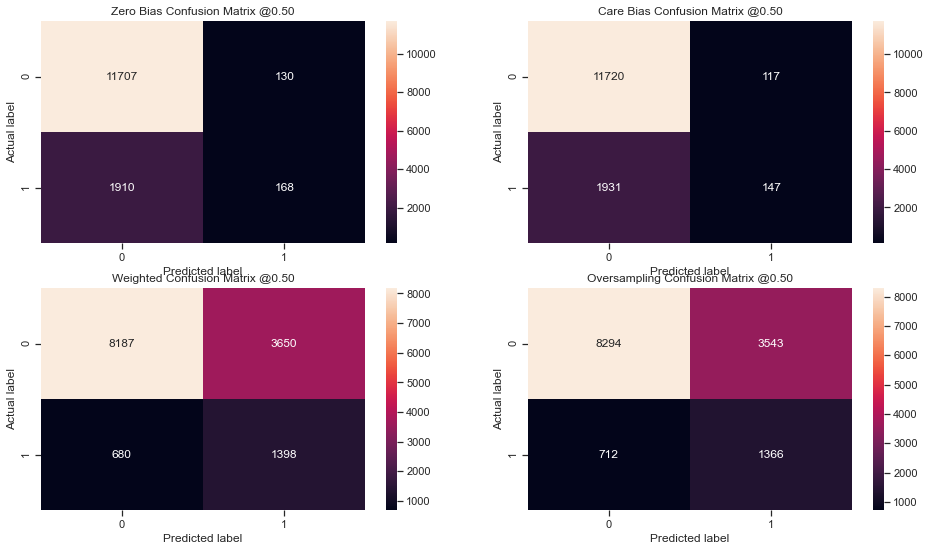

In [34]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(histories, targets, predictions, labels, p=0.5):
    plt.figure(figsize=(16.0, 9.0))
    for i, metric in enumerate(['loss', 'precision', 'recall', 'auc']):
        plt.subplot(2,2,i+1)
        for n, history in enumerate(histories):
            f_plot = plt.semilogy if metric == 'loss' else plt.plot
            f_plot(history.epoch,  history.history[metric], color=colors[n], label='Train ' + labels[n])
            f_plot(history.epoch,  history.history['val_' + metric], color=colors[n], label='Val '+labels[n], linestyle="--")
            plt.xlabel('Epoch')
            plt.ylabel(metric.capitalize())
            plt.legend()
            
    # ROC Curve
    plt.figure(figsize=(12.0, 8.0))
    for i, (target, prediction) in enumerate(zip(targets, predictions)):
        fp,tp,thresholds = roc_curve(target,prediction)
        plt.plot(100*fp, 100*tp, label=labels[i], linewidth=1.5, color=colors[i])
        plt.xlabel('False positives [%]')
        plt.ylabel('True positives [%]')
        plt.xlim([-0.5,100])
        plt.ylim([10,100])
        plt.legend()
        plt.grid(True)
        ax = plt.gca()
        ax.set_aspect('equal')
    
     # confusion matrix
    plt.figure(figsize=(16.0, 9.0))
    for i, (target, prediction) in enumerate(zip(targets, predictions)):
        plt.subplot(2, 2, i+1)
        cm = confusion_matrix(target, prediction > p)
        sns.heatmap(cm, annot=True, fmt='d')
        plt.title(labels[i] + ' Confusion Matrix @{:.2f}'.format(p))
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
plot_metrics(histories=[zero_bias_history, care_bias_history, weighted_history, oversampling_history], 
     targets=[y_test, y_test, y_test, y_test], predictions=[zero_preditions, care_preditions, weighted_preditions, 
     oversampling_preditions], labels=['Zero Bias', 'Care Bias', 'Weighted', 'Oversampling'])   

In [35]:
# Do oversampling to balance sample
print('Oversampling pre-sample:',Counter(y_train))
smo = SMOTE(random_state=42)
x_smo, y_smo = smo.fit_sample(x_train, y_train)
print('Oversampling sample:',Counter(y_smo))

Oversampling pre-sample: Counter({0: 47538, 1: 8119})
Oversampling sample: Counter({0: 47538, 1: 47538})


In [36]:
# LightGBM Model  

In [37]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report 

In [38]:
lgb_train = lgb.Dataset(x_smo, y_smo)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)
boost_round = 500
early_stop_rounds = 10

In [39]:
lgb_params = {
    'boosting_type':'gbdt',
    'objective':'binary',
    'metric':{'auc'},
    'max_depth':6,
    'num_leaves':34,
    'learning_rate':0.03,
    'feature_fraction':0.7,
    'bagging_fraction':0.5,
    'bagging_freq':5,
    "max_depth":10,
    'verbose':1,
}

In [40]:
results = {}
gbm = lgb.train(lgb_params, lgb_train, num_boost_round = boost_round,feature_name = [col for col in train.columns],
                valid_sets=(lgb_eval, lgb_train),valid_names=('validate', 'train'),
                early_stopping_rounds = early_stop_rounds,evals_result=results)

[LightGBM] [Info] Number of positive: 47538, number of negative: 47538
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.455225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 155710
[LightGBM] [Info] Number of data points in the train set: 95076, number of used features: 823
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[1]	train's auc: 0.906287	validate's auc: 0.679971
Training until validation scores don't improve for 10 rounds
[2]	train's auc: 0.916022	validate's auc: 0.691082
[3]	train's auc: 0.92024	validate's auc: 0.693443
[4]	train's auc: 0.934915	validate's auc: 0.702497
[5]	train's auc: 0.937	validate's auc: 0.703964
[6]	train's auc: 0.937086	validate's auc: 0.703605
[7]	train's auc: 0.939877	validate's auc: 0.705352
[8]	train's auc: 0.944107	validate's auc: 0.709791
[9]	train's auc: 0.946208	validate's auc: 0.711905
[10]	train's auc: 0.946988	validate's a

In [51]:
y_pred = gbm.predict(x_test,num_iteration=gbm.best_iteration)
y_pred[:10]

array([0.0646263 , 0.27130893, 0.47531531, 0.06299064, 0.15710161,
       0.05614908, 0.09313303, 0.2182376 , 0.13919658, 0.09691508])

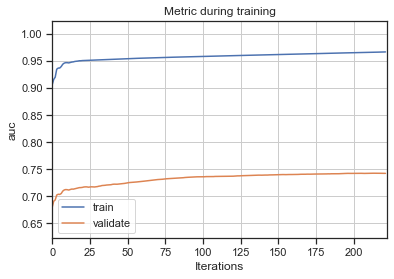

In [52]:
lgb.plot_metric(results)
plt.show()

In [53]:
scores = {}

gbm_accuracy = accuracy_score(y_test, y_pred.round())
scores['accuracy']=(gbm_accuracy)

gbm_auc = roc_auc_score(y_test, y_pred)
scores['AUC']=(gbm_auc)

gbm_precision = precision_score(y_test, y_pred.round())
scores['precision']=(gbm_precision)

gbm_recall = recall_score(y_test, y_pred.round())
scores['recall']=(gbm_recall)

gbm_f1_score = recall_score(y_test, y_pred.round())
scores['F1']=(gbm_f1_score)

print('Model_scores:',scores)

Model_scores: {'accuracy': 0.8539705353934602, 'AUC': 0.7428060559201531, 'precision': 0.5542452830188679, 'recall': 0.11308950914340712, 'F1': 0.11308950914340712}


In [44]:
from sklearn.metrics import roc_curve,auc

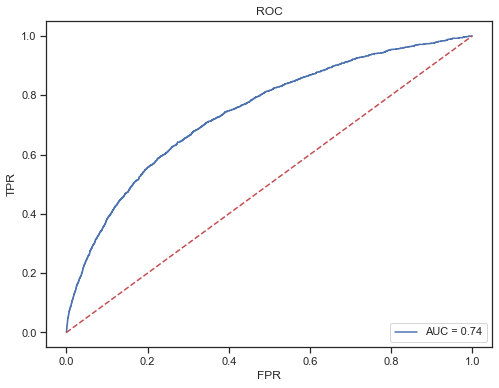

In [45]:
# ROC curve
plt.figure(figsize=(8.0, 6.0))
false_positive_rate,true_positive_rate,thresholds=roc_curve(y_test, y_pred)
roc_auc=auc(false_positive_rate, true_positive_rate)
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate,'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.close(0)

Top 100 Important Features


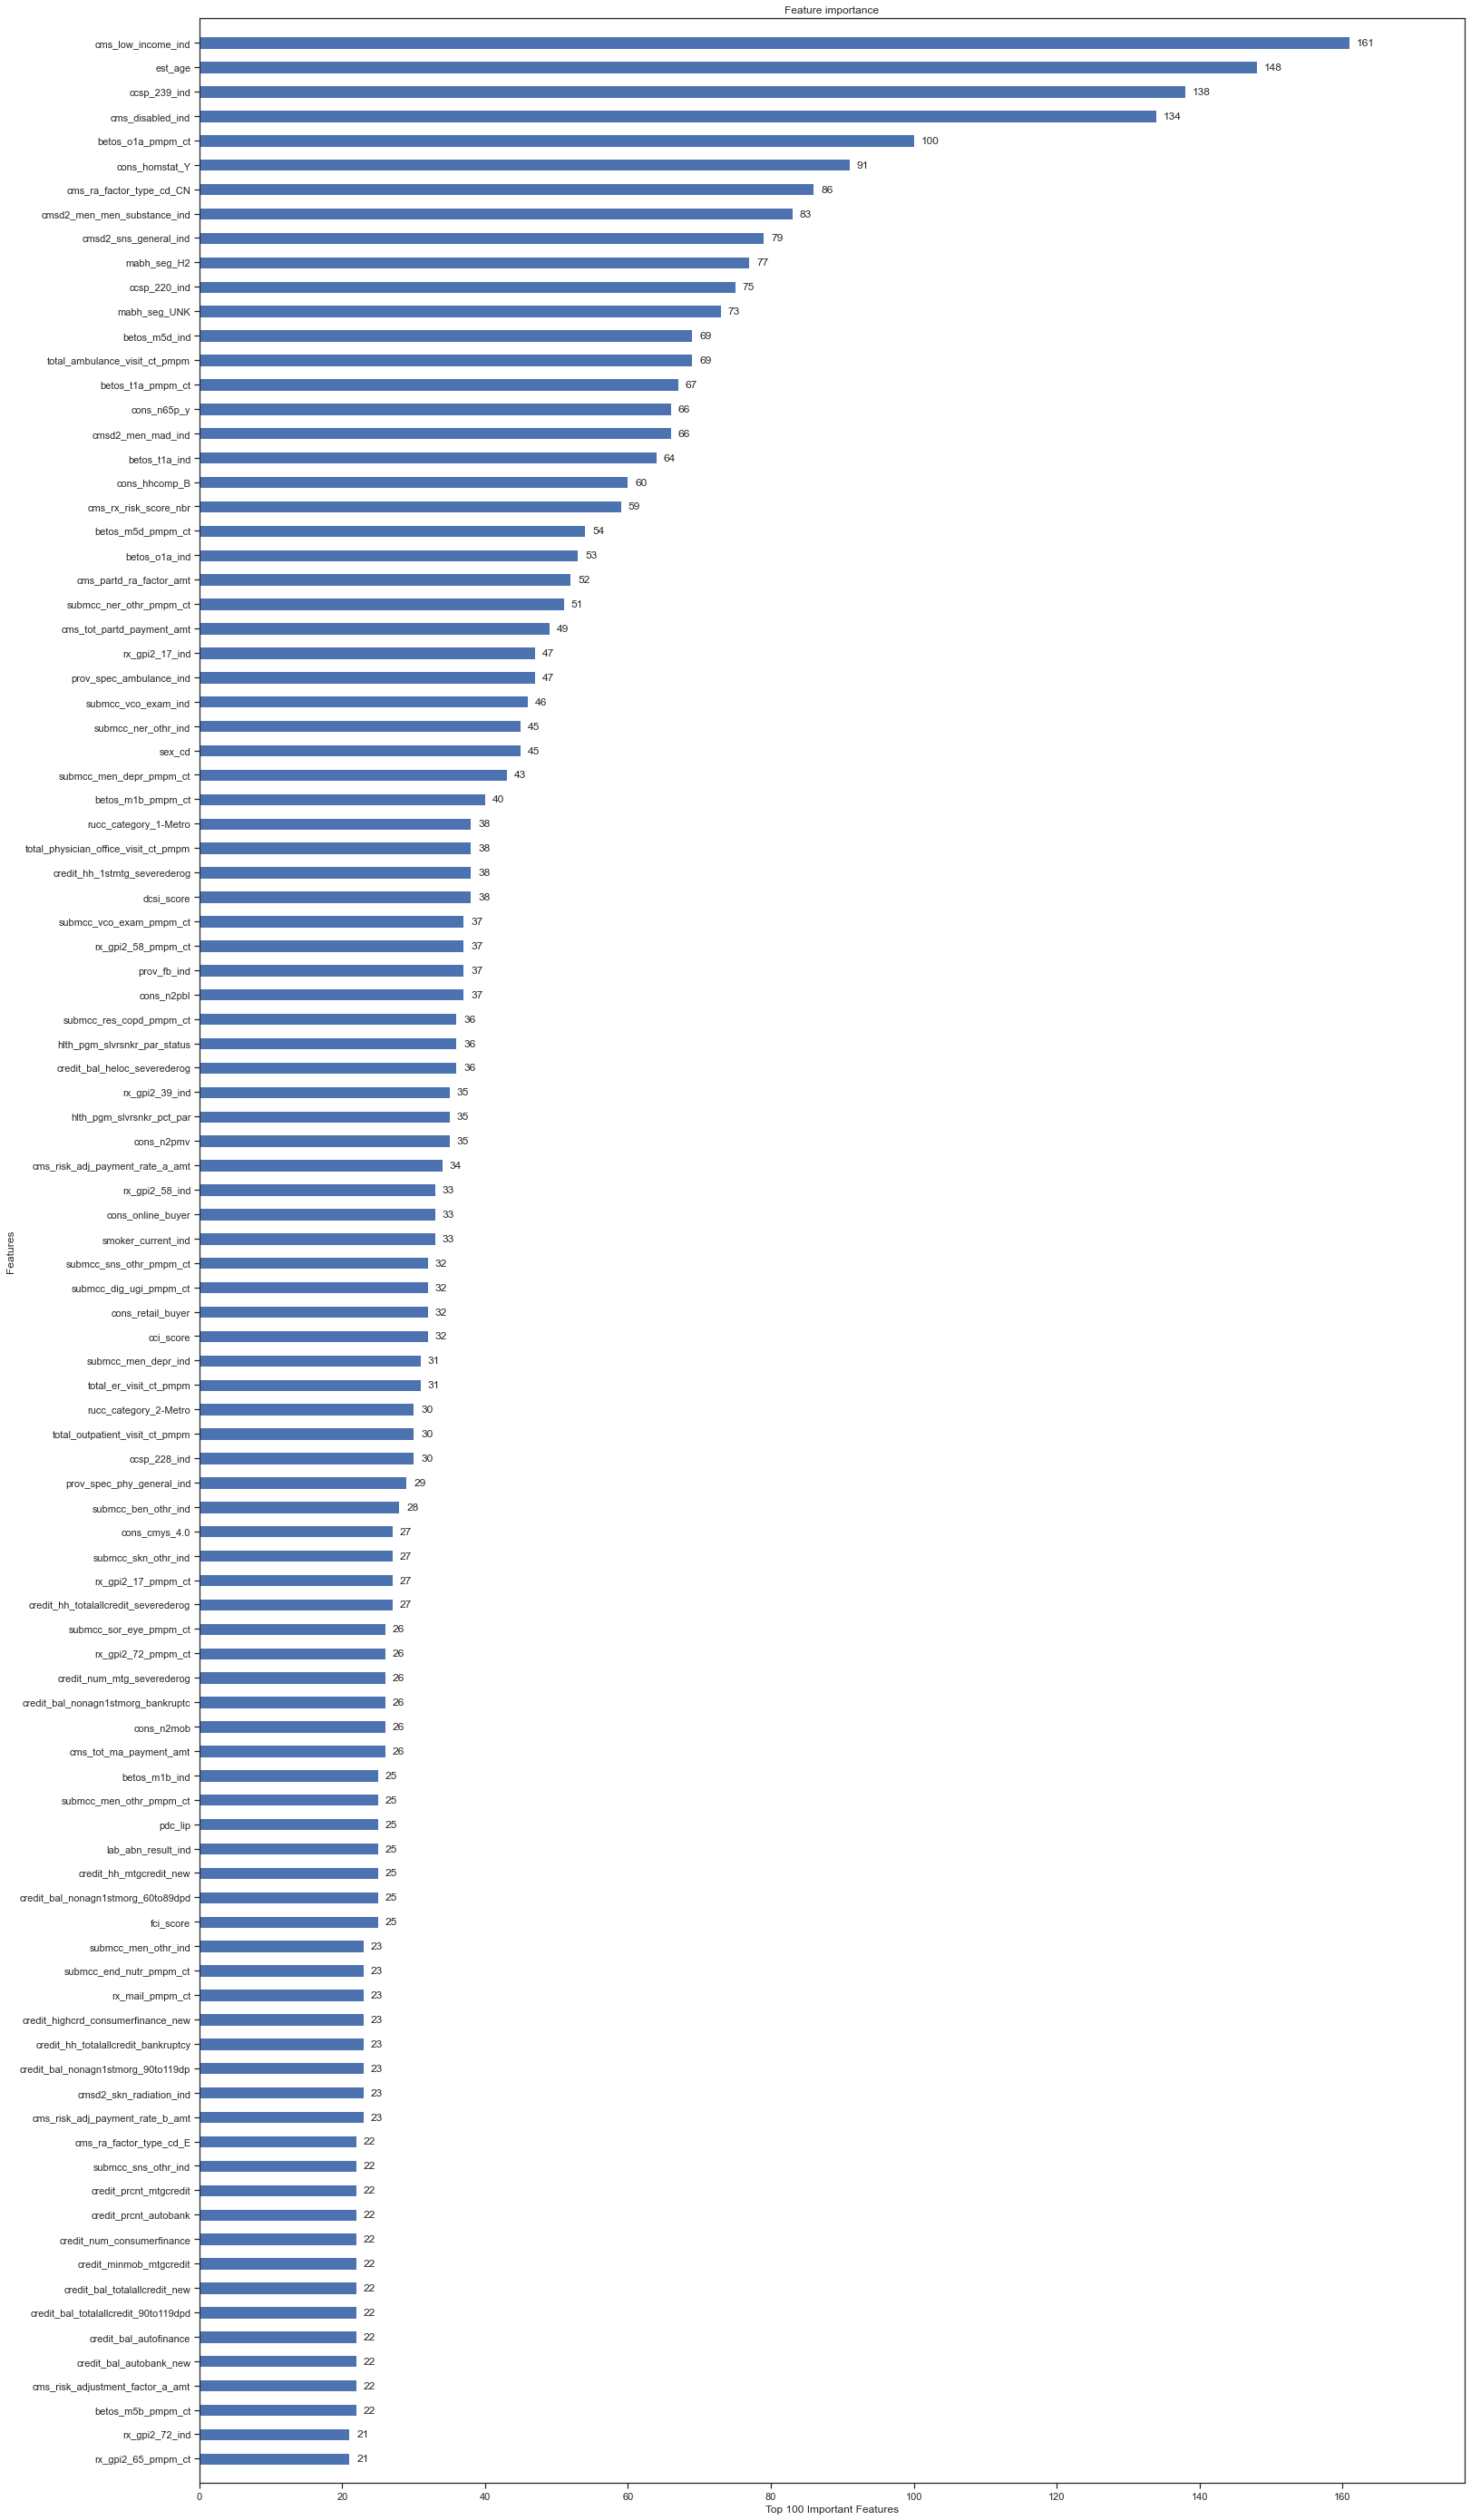

In [46]:
print('Top 100 Important Features')
lgb.plot_importance(gbm, max_num_features=100, figsize=(25, 50), grid=False, height=0.5, 
                    xlabel='Top 100 Important Features',  ylabel='Features')
plt.show()

In [47]:
gbm.save_model('Salus_model.txt')

In [48]:
# Transportation challenge prediction for Holdout dataset
# data numeric change for Holdout dataset
final_data = pd.read_csv("2020_Competition_Holdout .csv")
final_train = final_data.drop(columns ='person_id_syn')
le = LabelEncoder()
for col in final_train:
    if final_train[col].dtype == 'object':
        if len(list(final_train[col].unique()))<=2:
            le.fit(final_train[col])
            final_train[col]=le.transform(final_train[col])
final_train = pd.get_dummies(final_train)
final_train.head(10)

/Users/kiki/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (79) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,src_platform_cd,sex_cd,est_age,smoker_current_ind,smoker_former_ind,cci_score,dcsi_score,fci_score,hcc_weighted_sum,betos_d1c_pmpm_ct,...,state_cd_PR,state_cd_SC,state_cd_SD,state_cd_TN,state_cd_TX,state_cd_VA,state_cd_WA,state_cd_WI,state_cd_WV,state_cd_other
0,0,1,68,1,0,13.0,8,10,9,0.000000,...,0,0,0,0,0,0,0,0,0,0
1,0,0,65,0,0,3.0,2,3,0,0.000000,...,0,0,0,0,0,0,0,0,0,1
2,1,1,67,0,0,6.0,0,4,0,0.000000,...,0,0,0,0,0,0,0,0,0,1
3,0,0,76,0,0,6.0,3,2,4,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0,0,65,0,0,5.0,3,3,4,0.000000,...,0,0,0,0,0,0,0,0,0,1
5,0,0,56,1,0,8.0,5,7,0,0.868174,...,0,0,0,0,0,0,0,0,0,1
6,1,0,79,0,0,3.0,0,0,0,0.000000,...,0,0,0,0,0,0,0,0,0,1
7,1,1,81,0,0,4.0,0,2,4,0.000000,...,0,0,0,0,0,0,0,0,0,1
8,1,1,79,0,0,8.0,4,4,13,0.000000,...,0,0,0,0,0,0,0,0,0,1
9,1,1,76,0,0,11.0,4,7,8,0.000000,...,0,0,0,0,0,0,0,0,0,1


In [49]:
# Read the model and predict the results
# then sort ID rank by probablity of transportation challenge
gbm = lgb.Booster(model_file='Salus_model.txt')
y_pred = gbm.predict(final_train, num_iteration=gbm.best_iteration,predict_disable_shape_check=True)
transpor_pred = pd.DataFrame(y_pred, columns=['SCORE']) 
person_id_syn = final_data['person_id_syn']
transpor_pred['ID'] = person_id_syn
id_ = transpor_pred['ID']
transpor_pred = transpor_pred.drop('ID', axis=1)
transpor_pred.insert(0, 'ID', id_)
rank = transpor_pred.sort_values(by="SCORE" , ascending=False,ignore_index=True)
rank.index +=1 
rank.index.name='RANK'
rank.head(20)

,ID,SCORE
RANK,,
1,4Mc0OSTcLca94YA109cef0Ie,0.999414
2,dbaMbOS9bTL659Yd1bbedA7I,0.999394
3,410MO06abS5707TLe9YA8eIa,0.999394
4,72MdeO5aST28L2Yeb5aA4Ic4,0.999389
5,fbM10OSdTe0LYA6f4fdI1eab,0.999389
6,f6M584ca97OSaT3943L4YbAI,0.999389
7,88M48O418d0STb5eL52Yd6AI,0.999389
8,f22MdcfO1Sc31TLY89A28I0c,0.999388
9,MfOSTLb22Yd0A9345bI74e16,0.999388


In [54]:
rank.to_csv('CaseCompetition_Haoyue_Zheng.csv')